# Field Significance

The topic of field significance is broadly concerned with determining if the results of a correlation between a time series and the set of many time series that comprise a field of space-time data is significant.  While there are well-known parametric tests for assessing statistical significance and evaluating a null hypothesis, field correlations present at least two challenges to a conventional interpretation of a small _p-value_ as indicative of a meaningful relationship.  These include:

* a multiple comparison problem -- we are conducting a large number of correlation analyses, from which we would expect a certain proportion would meet any given significance threshold simply by chance, and effect we need to account for
* a spatial autocorrelation problem -- most of our spatial data will be dependent (correlated with one another as a function of space), with the implication that there are many fewer degrees of (spatial) freedom in our field correlation result than there are grid points and this must be accounted for

An excellent overall discussion of field significance is available in Chapter 13 of the book _[Statistical Methods for Climate Scientists](https://www.cambridge.org/us/universitypress/subjects/earth-and-environmental-science/climatology-and-climate-change/statistical-methods-climate-scientists?format=HB&isbn=9781108472418)_ by Timothy DelSole and [Michael Tippett](https://github.com/mktippett).  If you have library access, you may be able to find the chapter in PDF form [here](https://www.cambridge.org/core/books/statistical-methods-for-climate-scientists/field-significance/B4107B7D3330991718C5A0828679D03B).

Here we're going to look at 3 different tests, all of which are featured in your reading for this section of the course.  We'll first briefly look at the 'binomial test' from [Livezey and Chen (1983)](https://doi.org/10.1175/1520-0493(1983)111%3C0046:SFSAID%3E2.0.CO;2) before moving onto their Monte Carlo approach to field significance.  Finally, we'll look at the method of [False Discovery Rate](https://rss.onlinelibrary.wiley.com/doi/10.1111/j.2517-6161.1995.tb02031.x) (FDR), specifically as described in a climate science context by [Ventura et al. (2004)](https://doi.org/10.1175/3199.1).

Let's get started.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features


## Binomial Test Example

Livezey and Chen (1983) point out that because we are doing a finite number of comparisons (between a time series and a set of other time series), we can calculate the probability of falsely rejecting the null -- a Type 1 error -- using the binomial distribution.  In simple terms, we might ask ’how many individual significance tests must be passed (that is, significant at $p<0.05$) when trying $N$ experiments to ensure these don't indicate a meaningful field relationship by accident at a confidence level of $p=0.05$?'  However, a problem with using the binomial test will quickly become apparent, because our comparisons (and the test for a null hypothesis for each) are not _independent_ at all!  Spatial autocorrelation means that as we conduct mulitple correlations between a time series and the time series that make up a field, the spatial dependence violates the assumption of independence of each individual test from the others that is assumed in this test.

Nevertheless, this provide a useful first place to start to think about the concept of _field significance_.  In the Livezey and Chen approaches, we are not evaluating the significance of any individual point in our field correlation, but rather we are evaluating whether the number of significant values as a whole might arise by chance.  Or, to put it still another way, we are evaluating the significance of our correlation map as a whole, not at any individual location.

Let's repeat the example shown in Section 2 and Figure 2 of [Livezey and Chen (1983)](https://doi.org/10.1175/1520-0493(1983)111%3C0046:SFSAID%3E2.0.CO;2).  We will conduct their binomial test for N individual tests of correlation and an _a priori_ significance level of $\alpha=0.05$.  The binomial test allows us to calculate the probability of observing $x$ number of successful significance tests as a function of the number of tests and the alpha level:

$
Pr\{x\} = \frac{N!}{x!(N-x)!} \alpha^x (1-\alpha)^{N-x}
$

Let's see what this looks like:

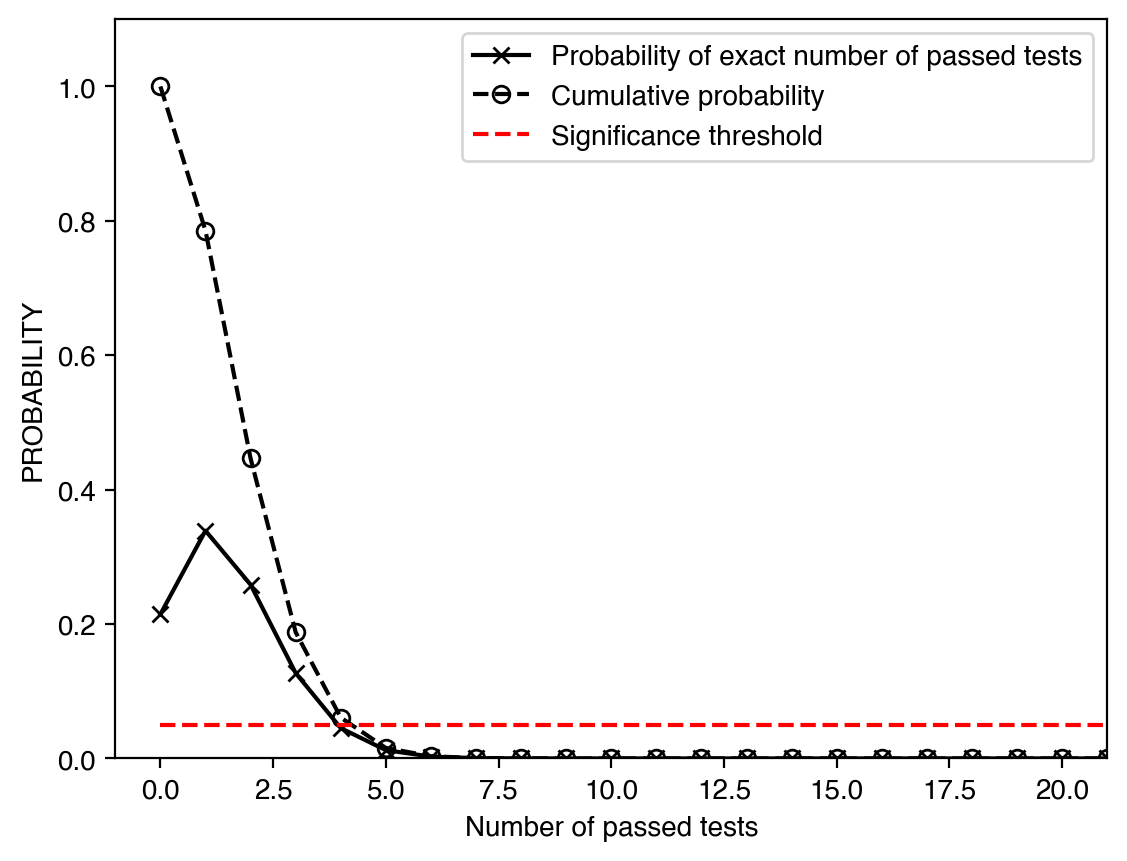

In [2]:
# Specify the number of tests and an a priori alpha
N = 30 # we calculate these many correlation values
alpha = 0.05 # a priori significance level

# Initialize arrays to store probabilities
Pr = np.zeros(N + 1)
P = np.zeros(N + 1)

# Binomial test - loop over sample size, this gives the is probability of any X == x
for x in range(N + 1):
    Pr[x] = (np.math.factorial(N) / (np.math.factorial(x) * np.math.factorial(N - x))) * alpha**x * (1 - alpha)**(N - x)

# Also create a cumulative probability for X >= x
for i in range(len(Pr)):
    P[i] = np.sum(Pr[i:])

# Plot the results of the test
plt.figure()
plt.plot(np.arange(0, N + 1), Pr, 'kx-', label='Probability of exact number of passed tests')
plt.plot(np.arange(0, N + 1), P, 'ko--', markerfacecolor="None", label='Cumulative probability') # label='P(M >= M_0)
plt.plot([0, 30], [0.05, 0.05], 'r--', label="Significance threshold")
plt.xlabel('Number of passed tests')
plt.ylabel('PROBABILITY')
plt.ylim((0,1.1))
plt.xlim(-1,21)
plt.legend(loc='upper right')


You can compare the above plot to Figure 2 in [Livezey and Chen (1983)](https://doi.org/10.1175/1520-0493(1983)111%3C0046:SFSAID%3E2.0.CO;2).  The binomial test suggests that for this simple system, you need to pass at least 5 significance tests out of the 30 you conduct in total to be confident -- at the given significance level -- that this result was unlikely to be observed simply by chance.  However, we already know that this is not appropriate for most spatial field correlations, because this only holds if those 30 tests are truly independent from one another.   

So what else might we do?  One thing we've hopefully grown accustomed to in this class are empirical and non-parametric approaches, including Monte Carlo procedures.  If the problem with binomial test is that the assumption of (spatial) independence is violated, how might we conduct a test which accounts for the fact that our field of time series are dependent in some way?  This leads us to the following approach to field correlation using field randomization and Monte Carlo methods.

## Random field significance tests

As Livezey and Chen point out:

> Large cross-correlations in the field reduce the so-called 'degrees of freedom' of the field in the same way that large lag autocorrelation reduce the number of effective samples in a time series. Instead of a set of N individual realizations, such a field should be viewed as $n<N$ independent clusters of closely related realizations.

In theory, then, if we could determine the 'true' degrees of freedom and the effective sample size, the equationa and approach above might be used even in the case of cross-correlation in the field by modifying the $N$ appropriately (as we discussed in lecture for the case of temporal autocorrelation).  But in most real fields, this is a non-trivial calculation.  Whereas we have relatively well-known methods for estimating lagged autocorrelation, in the complex spatial structure of a field, it is less clear how to assign a single number to the reduction in the effective sample size $n$ of individual tests. 

Livezey and Chen recognize this, and later in their paper write:

> ... when estimates of $n$ are unavailable or when experimental results fall within their range, the only recourse to evaluate field significance is a Monte Carlo simulation. This is because multivariate techniques cannot be applied to large numbers of relatively short geophysical time series ... There are a number of considerations in the design of Monte Carlo simulations.  First, the random component must be introduced in such a way as to retain the interdependence whose effects need to be evaluated.  Second, probabilities of chance outcomes under the null hypothesis in the actual experiment must be matched in the Monte Carlo simulation.  Third, enough simulations need to be performed to estimate the probability accurately

For our purposes here, the first of these considerations will be the one of most interest.  Simply put, how do we sufficiently 'simulate' the features of the field but still at the same time simulate our null condition?  There are potentially several answers to this, but below we'll see an approach that iteratively randomizes the temporal _order_ of the field while keeping the spatial ordering.  This preserves the spatial autocorrelation but destroys (or at least damages) the real temporal match between our time series and the field (alternatively, one could simply randomize the single time series itself, which should accomplish the same thing! But, I want you to see the more complicated approach of randomizing the field, in case it should prove useful).

Let's get our old friend the SOI and the 700mb height field to use for this example:

In [3]:
# read in the soi index as a DataSet
soi = xr.open_dataset("soi.nc",mask_and_scale=True,decode_times=False)

# check the units used for the DataSet
# print(soi["time"].attrs["units"]) # this reveals the units to be 'months since 1866-1-15'

## Because 'months' are not a well-defined thing, we need to change the time coordinate if we want to use xr.corr
# create a new monthly-resolution date range starting with the datum and make it as long as the current time coordinate
new_time = pd.date_range(start='1/01/1866',periods=len(soi["time"]),freq='M')

# apply this new time coordinate to our dataset in place of the old one
soi["time"]=pd.to_datetime(new_time)

# remove the SOI from the DataSet into a DataArray - not sure why this is necessary but seems to be for this to work? 
soi = soi["SOI"]

# final step - ensure that the time coordinate is year and month and that everything else is default
soi["time"] = pd.to_datetime(soi["time"].dt.strftime("%Y-%m"))

# Calculate the 5-month rolling mean, skipping NaN values
soi_ = soi.rolling(time=3).mean(skipna=True) # 3 months averages

# Select out month 3 (March) to get the average over DJF
djf_soi = soi_[soi_.time.dt.month == 2] # take the 3 month rolling averages ending in February
djf_soi = djf_soi.drop_isel(time=0)

In [4]:
hgt = xr.open_dataset("hgt.700mb.mon.mean.nc",mask_and_scale=True)
hgt = hgt["hgt"]

# Calculate the 5-month rolling mean, skipping NaN values
hgt_ = hgt.rolling(time=3).mean(skipna=True) # 3 month averages

# Select out month 3 (March) to get the average over DJF
djf_hgt = hgt_[hgt_.time.dt.month == 2] # take averages ending in February
djf_hgt = djf_hgt.squeeze(drop=True) # squeeze out and drop the singleton 'level' dimension

In [5]:
djf_hgt, djf_soi = xr.align(djf_hgt,djf_soi,join="inner") # hgt and sst now have the same time dimension!


In [6]:
fieldCorrelation = xr.corr(djf_soi,djf_hgt, dim="time")

# calculate the p-values directly using r values and the t-distribution
t = -abs(fieldCorrelation.values)*np.sqrt((len(djf_soi.time)-2)/(1-np.square(fieldCorrelation.values)))
pvalue = sp.stats.t.cdf(t, len(djf_soi.time) - 2) * 2 # multiply by 2 for two-sided test
sig = xr.DataArray(data=pvalue,dims=["lat","lon'"],coords=[fieldCorrelation.lat, fieldCorrelation.lon])


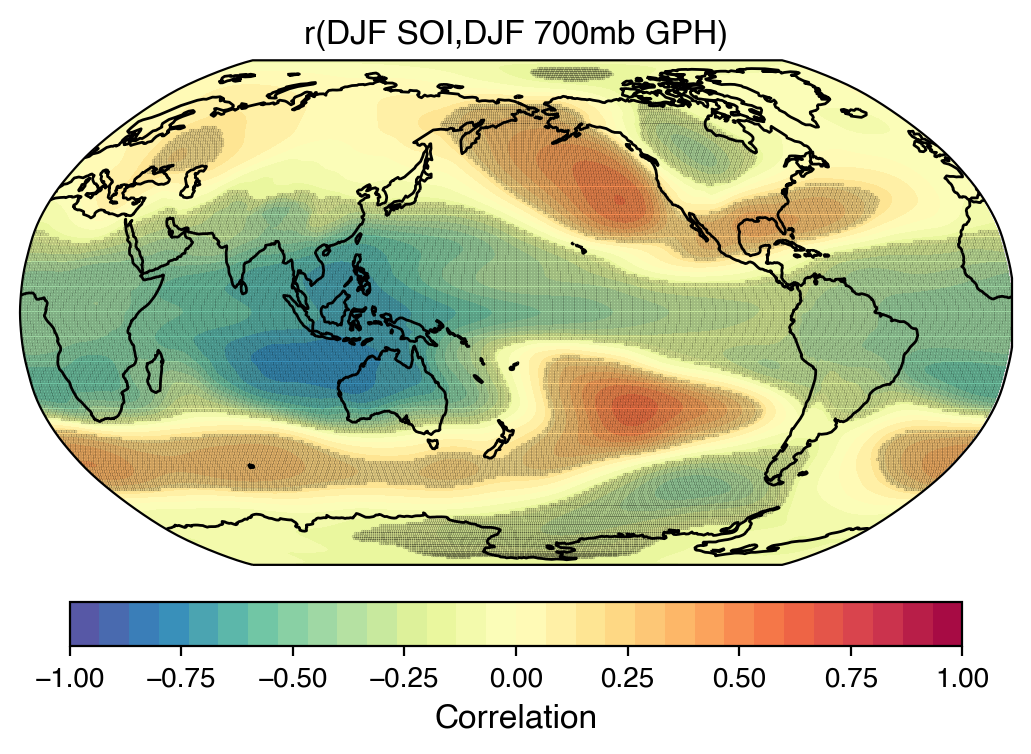

In [7]:
# defines areas with non-sigificant coefficients
sig_area1   = np.where(sig < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# plot the field correlations
fig, (ax1) = plt.subplots(clear=True,nrows=1,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(djf_hgt.lon,djf_hgt.lat,fieldCorrelation,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='horizontal',location='bottom',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
ax1.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.1, c = 'k', alpha = 0.4, transform = ccrs.PlateCarree())
cb1.set_label('Correlation', fontsize=12) 



In [8]:
numberSignificant = (sig<0.05).sum()
numberSignificant.values

array(34210)

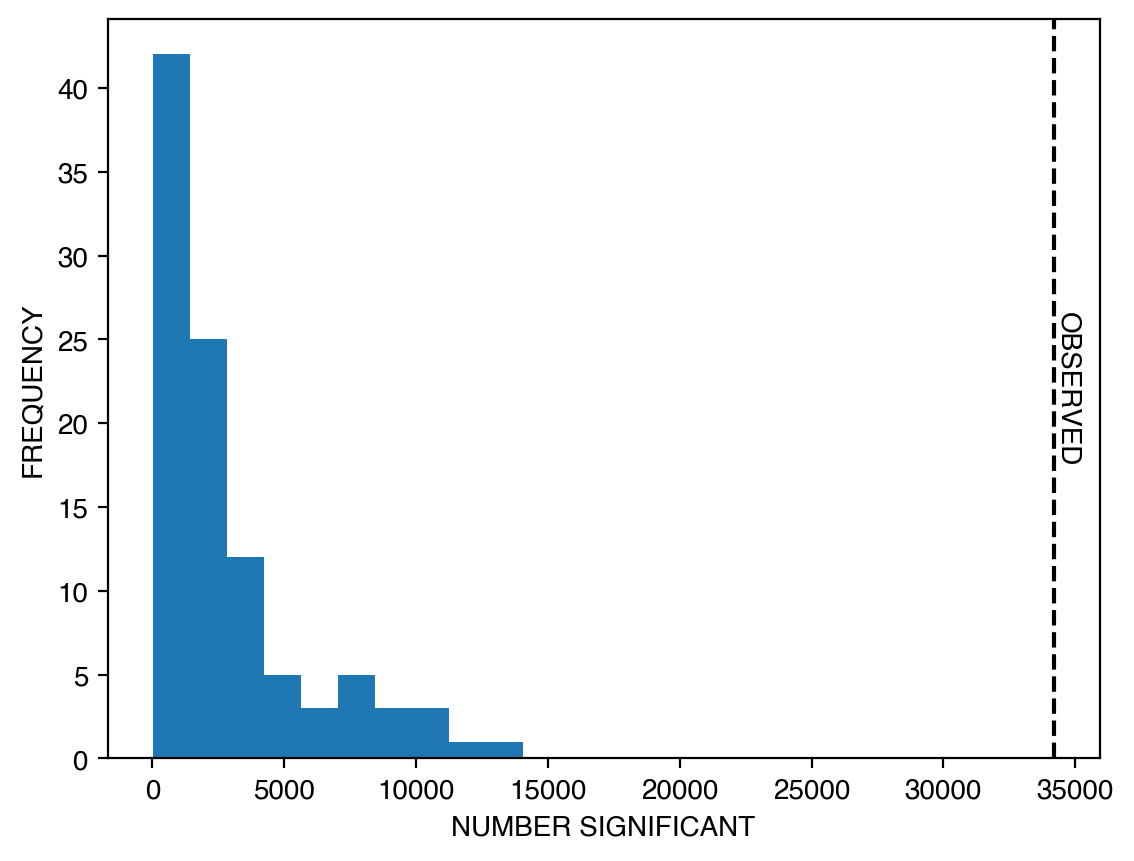

In [9]:
iterations = 100 # about 18 seconds for 100
randomNumberSignificant = np.empty(iterations)

rng = np.random.default_rng()

for i in range(iterations):
    random_array = djf_hgt.isel(time=rng.choice(djf_hgt.time.size, djf_hgt.time.size,replace=False)) 
    random_array["time"] = djf_hgt.time
    fieldCorrelation0 = xr.corr(djf_soi,random_array,dim="time")
    
    # calculate the p-values directly using r values and the t-distribution
    t0 = -abs(fieldCorrelation0.values)*np.sqrt((len(djf_soi.time)-2)/(1-np.square(fieldCorrelation0.values)))
    pvalue0 = sp.stats.t.cdf(t0, len(djf_soi.time) - 2) * 2 # multiply by 2 for two-sided test
    randomNumberSignificant[i] = (pvalue0<0.05).sum()
    if randomNumberSignificant[i] < 10000 and randomNumberSignificant[i] > 5000:
        sig_art = xr.DataArray(data=pvalue0,dims=["lat","lon'"],coords=[fieldCorrelation.lat, fieldCorrelation.lon])
        fieldCorrelation_art = fieldCorrelation0
        
fig, ax1 = plt.subplots()
ax1.hist(randomNumberSignificant)
ax1.axvline(numberSignificant,color="k",linestyle="--",label="Observed")
ax1.set_ylabel("FREQUENCY")
ax1.set_xlabel("NUMBER SIGNIFICANT")
ax1.text(numberSignificant,ax1.get_ylim()[1]/2,'OBSERVED',verticalalignment="center",rotation=-90);




The code above saves one of the random field correlation patterns and significance if it exceed 5,000 locally significant values but is less than 10,000.  These will be patterns where there is likely to be a specific location on the globe with a cluster of significant points, the kind of remote yet coherent looking teleconnection pattern you might see in a paleoclimate paper.  We can plot these here: 

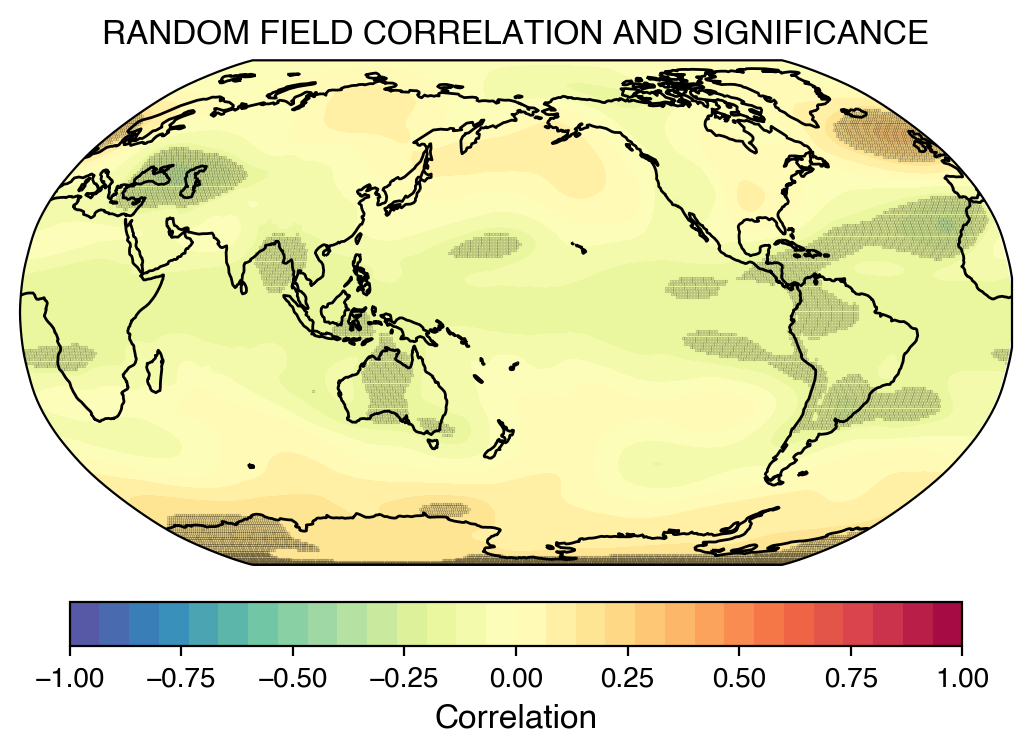

In [10]:
# defines areas with non-sigificant coefficients
sig_area_art   = np.where(sig_art < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# plot the field correlations
fig, (ax1) = plt.subplots(clear=True,nrows=1,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(djf_hgt.lon,djf_hgt.lat,fieldCorrelation_art,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('RANDOM FIELD CORRELATION AND SIGNIFICANCE', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='horizontal',location='bottom',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
ax1.scatter(lons[sig_area_art], lats[sig_area_art], marker = '.', s = 0.1, c = 'k', alpha = 0.4, transform = ccrs.PlateCarree())
cb1.set_label('Correlation', fontsize=12) 

But we can see that in this example, the number of passed local significance tests is much higher than the number that comes from the randomization Monte Carlo test:

In [11]:
significance_level = ((randomNumberSignificant<numberSignificant.values).sum()/iterations)*100
significance_level # highly, highly significant!

100.0

It is possible that shuffling the year order of the field is too 'liberal' if in fact there is important temporal autocorrelation in the time series.  In this case, it might be better to either shift (randomly) the series in time or to do a block shuffling, for which a package [`xbootstrap`](https://pypi.org/project/xbootstrap/) appears to make this easier in xarray. 

## The False Discovery Rate

The field significance via Monte Carlo and temporal randomization is used quite frequently, but all it does is tell us whether the total number of locally significant points is greater than expected for some null.  It does not tell us, however, where the local significance might rise to a level where we should interpret the local correlation as meaningful.  As Ventura et al. (2004) note:

> The method of Livezey and Chen (1983) detects field significance, with $p < 0.001$, but gives no indication about which particular locations are significant, even though this is of crucial interest. For that, we must test for a change at each location.

In fact the methods from Livezey and Chen (1983) can return an significance level we elect to use, but this does address the central question about _where_ the local correlation significant might exceed what could occur by chance in our multiple comparison situation.

Ventura et al. (2004) propose the use of the False Discovery Rate, originally described by ...

For the first time in this course, we'll also import the [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) package, which is designed specifically for the analysis of paleoclimate data.  It contains a function for the False Discovery Rate (FDR) test.  In fact, there are implementation of FDR in several Python packages, including ones we've already encountered.  But because the function in Pyleoclim arises specifically from Ventura et al. (2004) we'll use it here. 

In [12]:
# get the Pyleoclim package
import pyleoclim

`pyleoclim.utils.correlation.fdr` accepts a list or array of p-values, so we need to use `.ravel` to turn our 2-dimensional (longitude and latitude grid) set of p-values into a strung-out array.  We then pass that strung-out array to the function, which returns an index of the locations in the array with significant p-values at the q-level (here using the default 0.05). 

In [13]:
# False Discovery
pvals = np.random.uniform(0,0.1,size=(100))
fdr_idx = pyleoclim.utils.correlation.fdr(pvals)

In [14]:
pvals = pvalue.ravel()
fdr_idx = pyleoclim.utils.correlation.fdr(pvals,qlevel=0.05, method='original')
fdr_threshold = pvals[fdr_idx].max() # the maximum p-value that survived the FDR is our new threshold
sig_area2   = np.where(sig <= fdr_threshold) # this is a tuple! 


(0.0, 0.09)

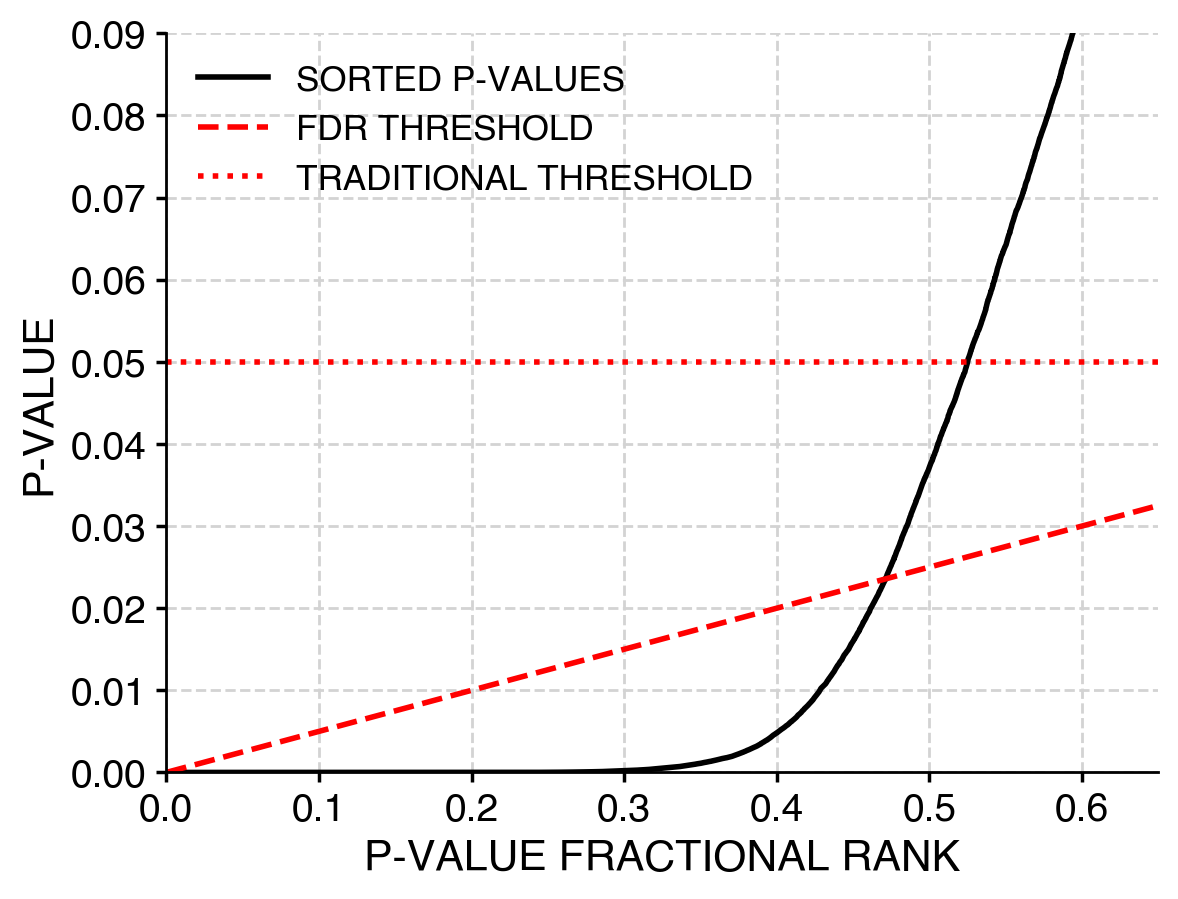

In [15]:
m = (np.arange(1,len(pvals)+1)/len(pvals))
fdr_line = m * 0.05

fig, ax1 = plt.subplots()
plt.plot(m,np.sort(pvals),'k-',label='SORTED P-VALUES')
plt.plot(m,fdr_line,color="r",linestyle="--",label='FDR THRESHOLD')
plt.plot([np.min(m),np.max(m)],[0.05,0.05],color='red',linestyle=":",label="TRADITIONAL THRESHOLD")
plt.xlabel('P-VALUE FRACTIONAL RANK')
plt.ylabel('P-VALUE')
plt.legend()
plt.xlim(0,0.65)
plt.ylim(0,0.09)

In [16]:
numberSignificantFDR = (sig<fdr_threshold).sum()
numberSignificantFDR.values

array(30701)

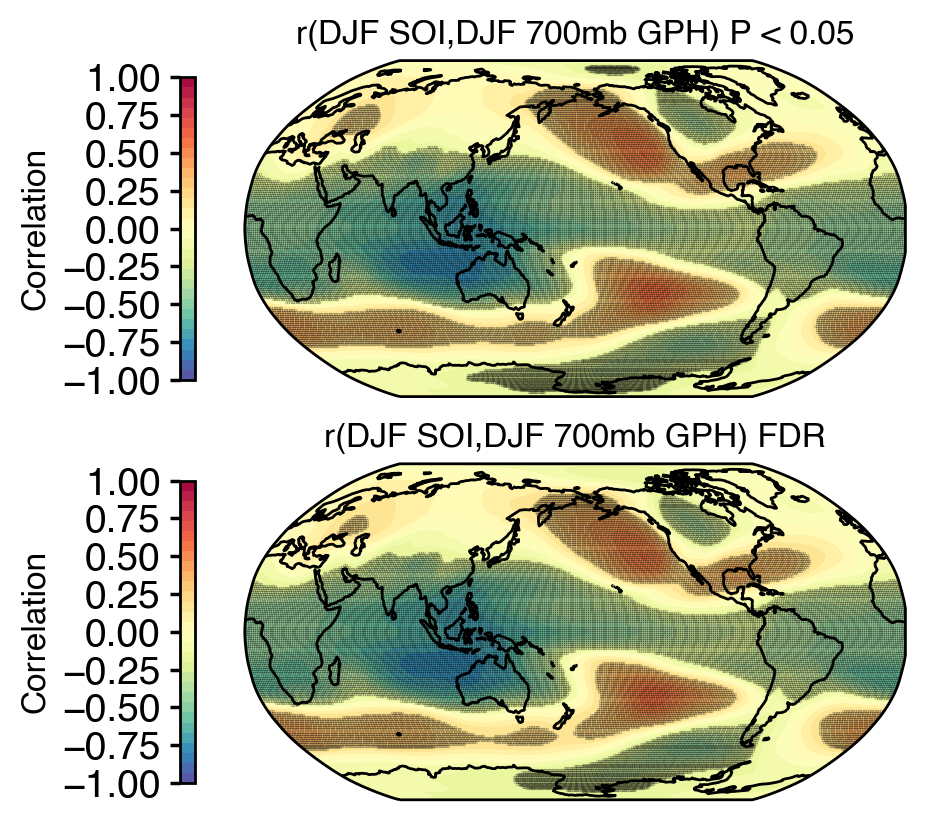

In [17]:
# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(djf_hgt.lon,djf_hgt.lat,fieldCorrelation,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI,DJF 700mb GPH) P < 0.05', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
ax1.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.1, c = 'k', alpha = 0.4, transform = ccrs.PlateCarree())
cb1.set_label('Correlation', fontsize=12) 

fx2 = ax2.contourf(djf_hgt.lon,djf_hgt.lat,fieldCorrelation,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(DJF SOI,DJF 700mb GPH) FDR', fontsize=12)
cb2 = plt.colorbar(fx2,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
ax2.scatter(lons[sig_area2], lats[sig_area2], marker = '.', s = 0.1, c = 'k', alpha = 0.4, transform = ccrs.PlateCarree())
cb2.set_label('Correlation', fontsize=12) 

One of the main subjects of the lectures that accompany this notebook is the issue of avoiding Type I and Type II errors.  There is no single approach that will optimize the trade off between these two errors, and as always my reminder to you is to be thoughtful and thorough in your approach to significance testing, the interpretation of meaningful relationships (or not) in your data, and mindful that the ultimate goal is to make robust and reasonable inferences and interpretations of the system (be it social or physical or both) of interest.  In a paper titled, _[To Bonferroni or not to Bonferroni: when and how are the questions](https://www.jstor.org/stable/20168454)_ in 2000, Cabin and Mitchell explored the issue of how to deal with multiple tests of significance and the potential for bias (emphasis mine): 

> Although overzealous use of Bonferroni corrections needlessly increases Type II error rates (i.e., accepting the null hypothesis when it is actually false), failing to use these corrections when needed inflates Type I error rates. **Both errors are important**, and slavish attention to one or the other will compromise the integrity of many statistical procedures. Unfortunately, the line between overzealousness and laxity is, in most cases, neither clear nor generally agreed upon. Determining what constitutes an appropriate grouping of statistical tests requires careful consideration of the way the statistics relate to the data and hypotheses of interest, and there are many situations in which reasonable and well-intentioned researchers may disagree about how to make these groupings and apply appropriate corrections



> Finally, authors, referees, and readers should strive to avoid blind adherence to particular P values; effect sizes, biological significance, and common sense ultimately may be the most important criteria for interpreting the results of all statistical tests